<a href="https://colab.research.google.com/github/Klevertak/DL_tasks/blob/master/tdl_lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: paths between minima of neural nets.

### 10 points total + 2 extra points.

*Disclaimer: we've tested the lab, however, if something doesn't work, you are free to change the given template.*

## Plan:

In this lab we are going to do some quantitative research concerning the loss landscape of neural nets. Specifically, we will try to answer the following two questions:
1. How "chaotic" is the loss landscape? Specifically, how common are local minima and saddle points?
2. Are local minima found by stochastic gradient descent (SGD) isolated or are they connected with a valley of small loss?

First, following [Goodfellow et al. (2014)](https://arxiv.org/abs/1412.6544), we are going to look at the loss on the linear segment connecting two different points:
1. Two random points;
2. Minimum found by SGD and its initialization point;
3. Minimum found by SGD and some other initialization point;
4. Two different minima found by SGD.

Then, following [Garipov et al. (2018)](https://arxiv.org/abs/1802.10026), we are going to fit the valley of small loss between two minima found by SGD (if it exists) with a simple curve.

## Part 0: preparation

In [0]:
import random
from typing import List, Tuple
from time import time
from copy import copy, deepcopy

import numpy as np

# We use pytorch 1.0 in our labs (we didn't test on other versions); 
# installation instructions are here: https://pytorch.org/ 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.distributions as distr
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')

In [2]:
USE_CUDA

True

Load MNIST dataset:

In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

input_shape = [1, 28, 28]
output_size = 10 # number of classes in MNIST
batch_size = 128 # you can change this number

dataloader_kwargs = {'num_workers': 0, 'pin_memory': True} if USE_CUDA else {}

dataset_train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
dataset_test = MNIST('./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, **dataloader_kwargs)

test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=True, **dataloader_kwargs)

0it [00:00, ?it/s]

9920512it [00:03, 2785539.92it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 57067.64it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 389770.92it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21774.96it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [10]:
len(train_loader), len(test_loader)

(469, 79)

In [0]:
class ReshapeLayer(nn.Module):
    """
    
A layer that accepts a tensor of shape [batch_size, *valid_shape]\
and returns a tensor of shape [batch_size, *target_shape],\
where valid_shape is compatible with target_shape.

    """
    def __init__(self, *target_shape):
        super(ReshapeLayer, self).__init__()
        self.target_shape = target_shape

    def forward(self, x):
        return x.view(x.shape[0], *self.target_shape)

We will experiment with a simple multi-layer fully-connected network:

In [0]:
class ClassifierFC(nn.Module):
    """
    
A fully-connected network with 'num_hidden' hidden layers of 'hidden_dim' neurons each,\
alternated with instances of 'nonlinearity'.
    
    """
    def __init__(self, input_shape, output_size, hidden_dim=50, num_hidden=1, nonlinearity=nn.ReLU):
        super(type(self), self).__init__()
        assert num_hidden >= 1, "the case 'hum_hidden' = 0 is not implemented"
        input_size = int(np.prod(input_shape))
        self.layers = nn.ModuleList([
            ReshapeLayer(input_size),
            nn.Linear(input_size, hidden_dim),
            nonlinearity()
        ])
        for _ in range(num_hidden-1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nonlinearity())
        self.layers.append(nn.Linear(hidden_dim, output_size))
        
    def forward(self, X):
        """

Forward pass through the network. Returns logits.
Expected input shape: [batch_size, *self.input_shape]
Output shape: [batch_size, output_size].

        """
        for layer in self.layers:
            X = layer(X)
        return X

In [0]:
class NullContext:
    def __enter__(self):
        pass
    
    def __exit__(self, *args):
        pass

This is our main train/validation routine:

In [0]:
def perform_epoch(model, loader, loss_function, optimizer=None):
    """

Performs one training or testing epoch, returns a tuple of mean loss and mean accuracy.\
If 'optimizer' is not None, performs an optimization step.

    """
    is_train = optimizer is not None
    
    if is_train:
        model.train()
    else:
        model.eval()

    cum_loss = 0
    cum_acc = 0
    cum_batch_size = 0

    with NullContext() if is_train else torch.no_grad():
        for X, y in loader:
            batch_size = X.shape[0]
            cum_batch_size += batch_size

            X = X.to(device)
            y = y.to(device)

            logits = model(X)
            loss = loss_function(logits, y)
            cum_loss += loss.item() * batch_size

            acc = torch.mean((torch.max(logits, dim=-1)[1] == y).float())
            cum_acc += acc.item() * batch_size

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    mean_loss = cum_loss / cum_batch_size
    mean_acc = cum_acc / cum_batch_size

    return mean_loss, mean_acc

## Part 1: Straight path between minima

In [0]:
num_minima = 2

state_dicts_at_minima = []
state_dicts_at_inits = []

### Task 1.1 (1 point)
Define your network. Train the network twice. Try to achieve 100% **train** accuracy (you'll probably have to decay your learning rate in some way). Save weights at initialization to *state_dicts_at_inits* and trained weights to *state_dicts_at_minima*.

*Remark: why do we need 100% train accuracy? Empirically, the default network (1 hidden layer with 64 neurons and ReLU nonlinearity) always achieves 100% train accuracy when properly trained (with decaying learning rate etc.), and optimization becomes easier when the network grows larger (but not too large). So, if you didn't achieve it, you are either in a "bad" local minimum, or you haven't trained your network hard enough (or, simply, you have a bug). According to our observations, the first alternative is quite unlikely for the default network. Hence being below 100% train accuracy mean being far from minimum.*

*Remark2. If you didn't achieve 100% train accuracy, and you are sure that you actually converged to a local minimum, please, save the result, weights of the network, network specification, random seed, etc; everything to reproduce this; and let me know.*

In [12]:
num_epochs = 100 # you can change this number
steps = len(train_loader)

for minimum_idx in range(num_minima):
    model = ClassifierFC(input_shape, output_size, num_hidden=1, hidden_dim=64, nonlinearity=nn.ReLU).to(device)
    
    # The model state (its weights, in particular) is stored in model.state_dict();
    # you can print it somewhere, if you are curious.
    # Here we append our freshly-initialized model state to state_dicts_at_inits:
    state_dicts_at_inits.append(deepcopy(model.state_dict()))

    loss_function = nn.CrossEntropyLoss()
    # YOUR CODE: create an optimizer and a c (pytorch has everything you need: see torch.optim)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
    
    for epoch in range(num_epochs):
        print('epoch', epoch+1)
        
        # YOUR CODE: optimize your network for one epoch (use perform_epoch)
        _loss, _acc = perform_epoch(model, train_loader, loss_function, optimizer)
        print("loss: {}, acc: {}".format(_loss, _acc))
        scheduler.step()
    # Here we append our trained model state to state_dicts_at_minima:
    state_dicts_at_minima.append(deepcopy(model.state_dict()))


epoch 1
loss: 0.47636346254348755, acc: 0.8807833333969116
epoch 2
loss: 0.2309317373275757, acc: 0.9347833333969117
epoch 3
loss: 0.1815160087108612, acc: 0.9483
epoch 4
loss: 0.1503284479379654, acc: 0.95675
epoch 5
loss: 0.1268432811121146, acc: 0.9632833333969116
epoch 6
loss: 0.10836618274450302, acc: 0.9694666666666667
epoch 7
loss: 0.09447552486260732, acc: 0.9726166666984558
epoch 8
loss: 0.08323970353802045, acc: 0.9759166666984558
epoch 9
loss: 0.0735000088274479, acc: 0.9785833333333334
epoch 10
loss: 0.06591383977333705, acc: 0.980616666730245
epoch 11
loss: 0.059528243984778725, acc: 0.9824833333969116
epoch 12
loss: 0.05358989303310712, acc: 0.9845833333651225
epoch 13
loss: 0.048418676050504046, acc: 0.9857666667302449
epoch 14
loss: 0.04317773121992747, acc: 0.98755
epoch 15
loss: 0.03964089269042015, acc: 0.9887333333969116
epoch 16
loss: 0.03636853890816371, acc: 0.989416666730245
epoch 17
loss: 0.032502080726623535, acc: 0.9912000000635783
epoch 18
loss: 0.0300194904

### Task 1.2 (2 points)
Compute train and test loss and accuracy on a straight line connecting two of the previously stored states. Plot the result.

In [0]:
# state_dicts_at_inits = state_dicts_at_inits[1:3]

In [0]:
from collections import OrderedDict

In [0]:
def interpolate_between_state_dicts(t, state_dict_a, state_dict_b):
    state_dict = OrderedDict()
    # YOUR CODE: compute a linear combination of two state dicts with coefficients t and 1-t
    for k in state_dict_a.keys():
      state_dict[k] = t*state_dict_a[k] + (1-t)*state_dict_b[k]
    return state_dict

In [0]:
train_losses = {}
train_accs = {}
test_losses = {}
test_accs = {}

In [0]:
# It is interesting to slightly extend the segment between two minima:
ts = np.linspace(0, 1.5, num=30)

In [0]:
from tqdm import tqdm_notebook

In [0]:
# interpolate_between_state_dicts(0.5,state_dicts_at_minima[0],state_dicts_at_minima[1])

In [33]:
mode = 'linear_combination_of_two_minima'

train_losses[mode] = []
train_accs[mode] = []

test_losses[mode] = []
test_accs[mode] = []
loss_function = nn.CrossEntropyLoss()
interp_model =  ClassifierFC(input_shape, output_size, num_hidden=1, hidden_dim=64, nonlinearity=nn.ReLU).to(device)


for t in tqdm_notebook(ts):
    # YOUR CODE: compute train and test loss and accuracy 
    # for a linear combination of model weights at two previously found minima 
    # with coefficients t and 1-t
    interpol_dict = interpolate_between_state_dicts(t,state_dicts_at_minima[0],state_dicts_at_minima[1])
    
    interp_model.load_state_dict(interpol_dict)    
    
    
    _loss,_acc = perform_epoch(interp_model, train_loader, loss_function, optimizer=None)
    train_losses[mode].append(_loss)
    train_accs[mode].append(_acc)
    
    _loss,_acc = perform_epoch(interp_model, test_loader, loss_function, optimizer=None)
    test_losses[mode].append(_loss)
    test_accs[mode].append(_acc)    

In [39]:
mode = 'linear_combination_of_minimum_and_init'

# YOUR CODE: do the same, but interpolate between one of the minima and the corresponding weight initialization

train_losses[mode] = []
train_accs[mode] = []

test_losses[mode] = []
test_accs[mode] = []
loss_function = nn.CrossEntropyLoss()
interp_model =  ClassifierFC(input_shape, output_size, num_hidden=1, hidden_dim=64, nonlinearity=nn.ReLU).to(device)


for t in tqdm_notebook(ts):
    # YOUR CODE: compute train and test loss and accuracy 
    # for a linear combination of model weights at two previously found minima 
    # with coefficients t and 1-t
    interpol_dict = interpolate_between_state_dicts(t,state_dicts_at_minima[0],state_dicts_at_inits[0])
    
    interp_model.load_state_dict(interpol_dict)    
    
    
    _loss,_acc = perform_epoch(interp_model, train_loader, loss_function, optimizer=None)
    train_losses[mode].append(_loss)
    train_accs[mode].append(_acc)
    
    _loss,_acc = perform_epoch(interp_model, test_loader, loss_function, optimizer=None)
    test_losses[mode].append(_loss)
    test_accs[mode].append(_acc) 

In [0]:
# test_accs

In [42]:
mode = 'linear_combination_of_minimum_and_random'

# YOUR CODE: the same, but interpolate between one of the minima and initialization for another minimum
train_losses[mode] = []
train_accs[mode] = []

test_losses[mode] = []
test_accs[mode] = []
loss_function = nn.CrossEntropyLoss()
interp_model =  ClassifierFC(input_shape, output_size, num_hidden=1, hidden_dim=64, nonlinearity=nn.ReLU).to(device)


for t in tqdm_notebook(ts):
    # YOUR CODE: compute train and test loss and accuracy 
    # for a linear combination of model weights at two previously found minima 
    # with coefficients t and 1-t
    interpol_dict = interpolate_between_state_dicts(t,state_dicts_at_minima[1],state_dicts_at_inits[0])
    
    interp_model.load_state_dict(interpol_dict)    
    
    
    _loss,_acc = perform_epoch(interp_model, train_loader, loss_function, optimizer=None)
    train_losses[mode].append(_loss)
    train_accs[mode].append(_acc)
    
    _loss,_acc = perform_epoch(interp_model, test_loader, loss_function, optimizer=None)
    test_losses[mode].append(_loss)
    test_accs[mode].append(_acc) 

In [43]:
mode = 'linear_combination_of_two_randoms'

# YOUR CODE: the same, but interpolate between two pre-saved weight initializations
train_losses[mode] = []
train_accs[mode] = []

test_losses[mode] = []
test_accs[mode] = []
loss_function = nn.CrossEntropyLoss()
interp_model =  ClassifierFC(input_shape, output_size, num_hidden=1, hidden_dim=64, nonlinearity=nn.ReLU).to(device)


for t in tqdm_notebook(ts):
    # YOUR CODE: compute train and test loss and accuracy 
    # for a linear combination of model weights at two previously found minima 
    # with coefficients t and 1-t
    interpol_dict = interpolate_between_state_dicts(t,state_dicts_at_inits[0],state_dicts_at_inits[1])
    
    interp_model.load_state_dict(interpol_dict)    
    
    
    _loss,_acc = perform_epoch(interp_model, train_loader, loss_function, optimizer=None)
    train_losses[mode].append(_loss)
    train_accs[mode].append(_acc)
    
    _loss,_acc = perform_epoch(interp_model, test_loader, loss_function, optimizer=None)
    test_losses[mode].append(_loss)
    test_accs[mode].append(_acc) 

Plot the corresponding results:

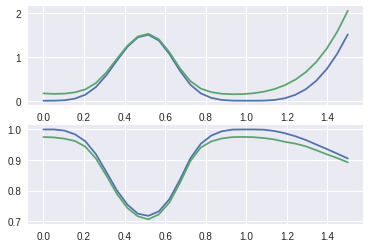

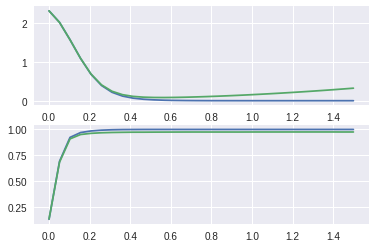

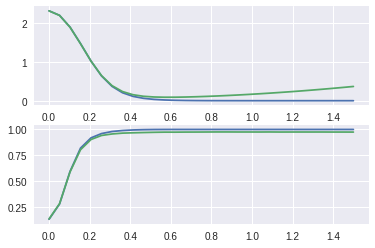

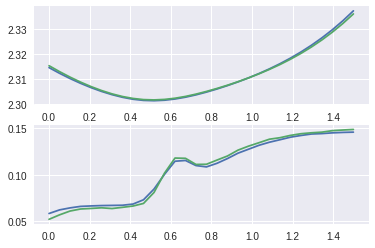

In [61]:
# YOUR CODE: make nice plots
plt.subplot(2, 1, 1)
plt.plot(ts,train_losses['linear_combination_of_two_minima'])
plt.plot(ts,test_losses['linear_combination_of_two_minima'])
plt.subplot(2, 1, 2)
plt.plot(ts,train_accs['linear_combination_of_two_minima'])
plt.plot(ts,test_accs['linear_combination_of_two_minima'])

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(ts,train_losses['linear_combination_of_minimum_and_init'])
plt.plot(ts,test_losses['linear_combination_of_minimum_and_init'])
plt.subplot(2, 1, 2)
plt.plot(ts,train_accs['linear_combination_of_minimum_and_init'])
plt.plot(ts,test_accs['linear_combination_of_minimum_and_init'])

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(ts,train_losses['linear_combination_of_minimum_and_random'])
plt.plot(ts,test_losses['linear_combination_of_minimum_and_random'])
plt.subplot(2, 1, 2)
plt.plot(ts,train_accs['linear_combination_of_minimum_and_random'])
plt.plot(ts,test_accs['linear_combination_of_minimum_and_random'])

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(ts,train_losses['linear_combination_of_two_randoms'])
plt.plot(ts,test_losses['linear_combination_of_two_randoms'])
plt.subplot(2, 1, 2)
plt.plot(ts,train_accs['linear_combination_of_two_randoms'])
plt.plot(ts,test_accs['linear_combination_of_two_randoms'])


Charactarize loss and accuracy on segments you've just tried.

Questions to think about:
* Can you characterize the loss landscape as "chaotic" or "regular"?
* Do train and test curves look quantitatively same or differently?

## Part 2: Constructing an optimal one-bend chain connecting two minima

Suppose we have two points $w_1$ and $w_2$ which are both minima of a loss of our network on the train dataset $\mathcal{L}_{train}(w)$. 
Let $\theta$ be some point in the weight-space.
Let $\phi_{\theta}(t)$ be a chain composed of two linear segments: first one connecting $w_1$ and $\theta$, and the second one connecting $\theta$ and $w_2$. 
We choose parameterization such that $\phi_{\theta}(0) = w_1$, $\phi_{\theta}(1) = w_2$ and $\phi_{\theta}(0.5) = \theta$.

Recall we are looking for a valley of small loss.
We are going to approximate this valley with our one-bend chain.
In order to do this we are going to minimize an average loss over the chain:
$$
\mathcal{L}_{chain}(\theta) = \mathbb{E}_{w \sim U(\phi_{\theta})} \mathcal{L}_{train}(w) \to \min_{\theta},
$$
where $U(\phi_{\theta})$ denotes a uniform distribution of weights over chain.

It is not easy to optimize this objective with SGD. That's why we further follow [Garipov et al. (2018)](https://arxiv.org/abs/1802.10026) to approximate our objective as follows:
$$
\tilde{\mathcal{L}}_{chain}(\theta) = \mathbb{E}_{t \sim U[0,1]} \mathcal{L}_{train}(\phi_\theta(t)) \to \min_{\theta}.
$$

The latter objective could be easily optimized with gradient methods:
$$
\nabla_{\theta} \tilde{\mathcal{L}}_{chain}(\theta) = \mathbb{E}_{t \sim U[0,1]} \nabla_{\theta} \mathcal{L}_{train}(\phi_\theta(t)),
$$
where we can unbiasedly estimate the expectation over $t$ with Monte-Carlo samples:
$$
\mathbb{E}_{t \sim U[0,1]} \nabla_{\theta} \mathcal{L}_{train}(\phi_\theta(t)) \approx
\nabla_{\theta} \mathcal{L}_{train}(\phi_\theta(\tilde t)), \quad \tilde{t} \sim U[0,1].
$$

### Task 2.1 (1 point)
Derive an exact formula for $\phi_{\theta}(t)$.

### Task 2.2 (2 points)
Find an optimal bend for two minima found before. Where you able to optimize a bend to small mean loss on a chain?

In [0]:
# Here we initialize state_dict_at_theta as a state dict 
# in the middle of the segment connecting two minima we have previously found;
# theta_params is a list of trainable model weights at theta; these are the weights we are going to optimize:
state_dict_at_theta = OrderedDict()
theta_params = []
for param_key in state_dicts_at_minima[0].keys():
    state_dict_at_theta[param_key] = (state_dicts_at_minima[0][param_key] + state_dicts_at_minima[1][param_key]) / 2
    try:
        state_dict_at_theta[param_key].requires_grad_()
        theta_params.append(state_dict_at_theta[param_key])
    except RuntimeError:
        pass

In [0]:
def get_state_dict_from_chain(t, state_dict_at_w1, state_dict_at_w2, state_dict_at_theta):
    state_dict = OrderedDict()
    # YOUR CODE: compute a state dict at point t of the bend following formula you have just derived
    return state_dict

In [0]:
# YOUR CODE: create an optimizer and a learning rate scheduler for theta_params we are going to optimize
num_epochs = 100 # you are free to change this number

for epoch in range(num_epochs):
    print('epoch', epoch+1)

    cum_loss = 0
    cum_acc = 0
    cum_batch_size = 0

    model.eval()
    for X, y in train_loader:
        batch_size = X.shape[0]
        cum_batch_size += batch_size

        X = X.to(device)
        y = y.to(device)
        
        t = np.random.rand()
        # YOUR CODE: set state_dict of a model to a point on a chain that corresponds to t
        # HINT: use model.load_state_dict()

        logits = model(X)
        loss = loss_function(logits, y)
        cum_loss += loss.item() * batch_size

        acc = torch.mean((torch.max(logits, dim=-1)[1] == y).float())
        cum_acc += acc.item() * batch_size

        optimizer.zero_grad()
        # YOUR CODE: first, compute gradients of train loss wrt model weights at \phi_{\theta}(t);
        # then, given them, compute gradients of train loss at \phi_{\theta}(t) wrt \theta
        optimizer.step()

    mean_train_loss = cum_loss / cum_batch_size
    mean_train_acc = cum_acc / cum_batch_size

    print('train:')
    print('loss = {:.4f}; acc = {:.2f}'.format(mean_train_loss, mean_train_acc*100))

    # Uncomment if you use lr scheduler:
    #scheduler.step()

Visualize train and test loss and accuracy on a chain you have found:

In [0]:
mode = '1-bend_chain'

train_losses[mode] = []
train_accs[mode] = []

test_losses[mode] = []
test_accs[mode] = []

for t in tqdm_notebook(ts):
    # TODO: compute train and test loss and accuracy at the chain you've just found
    # for a given t using formula you've derived

In [0]:
# YOUR CODE: more nice plots

Compare losses / accuracy on a bend and on a segment connecting two minima:

In [0]:
# YOUR CODE: even more nice plots

### Task 2.3 (1 point):
Ok, we've just found an optimal bend $\theta$ for two different minima $w_1$ and $w_2$.
Define $u = w_2 - w_1$ and $v = \theta - w_1$.
As long as $\theta$ doesn't lie on a straight line connecting $w_1$ and $w_2$, our chain lie on a plane spanned by vectors $u$ and $v$.

However, in order to visualize loss on this plane nicely, we need to derive an orthogonal basis there.
Vectors $u$ and $v$ are not generally orthogonal.

First, derive two vectors $\hat u$ and $\hat v$ that span the same plane as $u$ and $v$ while being orthogonal.

In [0]:
u_state_dict = OrderedDict()
v_state_dict = OrderedDict()

with torch.no_grad():
    for param_key in state_dict_at_theta.keys():
        u_state_dict[param_key] = state_dicts_at_minima[1][param_key] - state_dicts_at_minima[0][param_key]
        v_state_dict[param_key] = state_dict_at_theta[param_key] - state_dicts_at_minima[0][param_key]

hat_u_state_dict = OrderedDict()
hat_v_state_dict = OrderedDict()

# YOUR CODE: compute hat_u_state_dict and hat_v_state_dict using formula you've just derived

### Task 2.4 (1 point)
Visualize your network train loss on a plane spanned by $\hat u$ and $\hat v$; visualize your chain on the same plot. Do you see a valley of small loss? Does your chain approximate this valley well?

In [1]:
train_losses_grid = []
train_accs_grid = []

test_losses_grid = []
test_accs_grid = []

ts = np.linspace(-1, 2, num=30) # this specification heavily depends on lenghts of vectors \hat u and \hat v;
ss = np.linspace(-1, 2, num=30) # hence you probably will need to modify it

for t in tqdm_notebook(ts):
    train_losses_grid.append([])
    train_accs_grid.append([])
    
    test_losses_grid.append([])
    test_accs_grid.append([])
    
    for s in tqdm_notebook(ss):
        state_dict = OrderedDict()
        # YOUR CODE: compute state_dict on a plane spanned by hat_u_state_dict and hat_v_state_dict with coeffs t and s;
        # load it to the model; compute train and test loss and accuracy at this point
        # HINT: evaluating model on a whole train/test dataset can take too much time;
        # if iterations run to slowly, you can evaluate your model on some fixed subset of each dataset.

NameError: ignored

In [0]:
# YOUR CODE: make contour plots
# Attention: there could be very high loss at the plane you span;
# so, in order to see the actual valley, you will probably have to adjust 'levels' argument of plt.contourf()

### Task 3.1 (2 points) 
Try deeper/wider network. Try sigmoid instead of ReLU. Does anything change quantitatively? If yes, indicate what.
You can just clone this notebook and do the same with new network.

### Task 3.2 (optional; 2 points extra) 
Take a serious convolutional architecture with ~~black-jack~~ batch-norms and dropouts, say, VGG (see, https://pytorch.org/docs/stable/torchvision/models.html#id2). Perform the same set of experiments on it.